In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from shutil import copy2

In [2]:
import tensorflow_hub as hub

In [3]:
# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [4]:
data_root = (r'E:\model\train')

In [5]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 542 images belonging to 2 classes.
Found 2172 images belonging to 2 classes.


In [6]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 2))

In [7]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Invalid image': 0, 'Valid image': 1}


In [8]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [10]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [11]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
 train_generator, 
 epochs=3,
 verbose=1,
 steps_per_epoch=steps_per_epoch,
 validation_data=valid_generator,
 validation_steps=val_steps_per_epoch).history

Epoch 1/3
68/68 [==============================] - 132s 2s/step - loss: 0.0889 - acc: 0.9669 - val_loss: 0.0267 - val_acc: 0.9926
Epoch 2/3
68/68 [==============================] - 142s 2s/step - loss: 0.0289 - acc: 0.9903 - val_loss: 0.0252 - val_acc: 0.9908
Epoch 3/3
68/68 [==============================] - 94s 1s/step - loss: 0.0196 - acc: 0.9922 - val_loss: 0.0238 - val_acc: 0.9926


In [12]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

17/17 [==============================] - 17s 1s/step - loss: 0.0238 - acc: 0.9926
Final loss: 0.02
Final accuracy: 99.26%


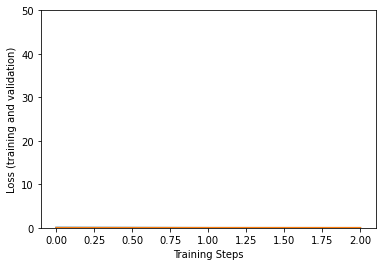

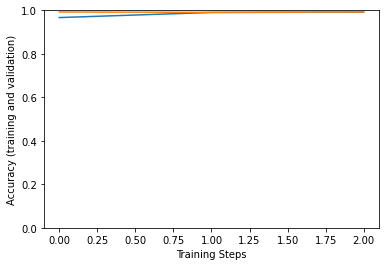

In [13]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [14]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [15]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Invalid Image' 'Valid Image']


In [16]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 2)


In [17]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Valid Image' 'Valid Image' 'Valid Image' 'Valid Image' 'Valid Image'
 'Valid Image' 'Invalid Image' 'Valid Image' 'Valid Image' 'Valid Image'
 'Valid Image' 'Valid Image' 'Valid Image' 'Invalid Image' 'Valid Image'
 'Valid Image' 'Valid Image' 'Valid Image' 'Invalid Image' 'Valid Image'
 'Valid Image' 'Valid Image' 'Valid Image' 'Valid Image' 'Valid Image'
 'Valid Image' 'Valid Image' 'Invalid Image' 'Valid Image' 'Invalid Image'
 'Valid Image' 'Valid Image']


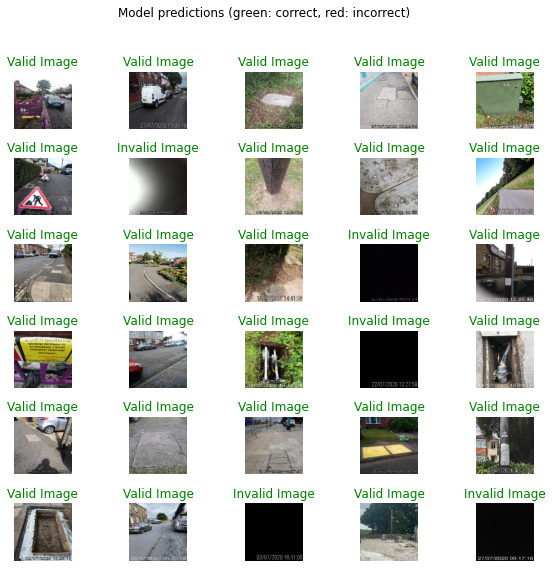

In [18]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [19]:
model_1 = model.save('E:\sample\model.h5')